In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import shutil
from tqdm.auto import tqdm
import sys
import PIL as pil
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import gc
import timm
import einops

In [21]:
class SimpleCnn(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layer1 = nn.Conv2d(in_channels=3,
                                out_channels=8,
                                kernel_size=(3,3),
                                stride=2,
                                padding=1)
        
        self.layer2 = nn.Conv2d(in_channels=8,
                                out_channels = 16,
                                kernel_size=(3,3),
                                stride=2,
                                padding=1)
        
        self.layer3 = nn.Conv2d(in_channels=16,
                                out_channels=32,
                                kernel_size=(3,3),
                                stride=2,
                                padding=1)
        
        self.layer4 = nn.Conv2d(in_channels=32,
                                out_channels=32,
                                kernel_size=(3,3),
                                stride=2,
                                padding=1)
        self.layer5  = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Linear(32,self.num_classes)
    def forward(self, x):
        x = nn.ReLU()(self.layer1(x))
        x = nn.ReLU()(self.layer2(x))
        x = nn.ReLU()(self.layer3(x))
        x = nn.ReLU()(self.layer4(x))
        x = self.layer5(x).squeeze()
        x = self.head(x)
        return x
    
        

In [22]:
train_transform = transforms.Compose([
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.RandomVerticalFlip(),
#                                 transforms.RandomRotation(60),
                                transforms.ToTensor()
                               ])
test_transform = transforms.Compose([
#                                 transforms.Resize((128,128)),
                            transforms.ToTensor()
                           ])
dataset_Train = datasets.ImageFolder(f'./Data/Train/', transform=train_transform)
dataset_Test = datasets.ImageFolder(f'./Data/Test/', transform =test_transform)
dataloader_train = torch.utils.data.DataLoader(dataset_Train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_Test, batch_size=32, shuffle=True)

In [23]:
data = next(iter(dataloader_train))

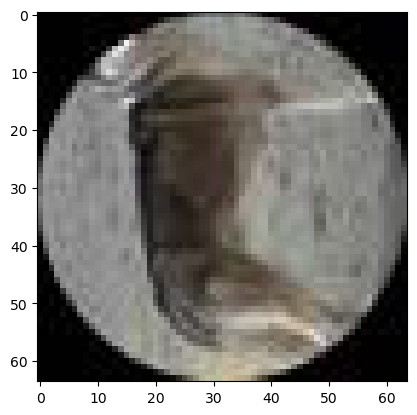

In [24]:
plt.imshow(data[0][0,...].T)

In [25]:
model = SimpleCnn(120)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose = True,threshold = 0.001,patience = 3, factor = 0.5)
model = model.to("cuda")

In [26]:
# scaler = torch.cuda.amp.GradScaler()


for epoch in range(100):
    train_loss = 0
    val_loss = 0
    train_steps = 0
    test_steps = 0
    label_list = []
    outputs_list = []
    train_auc = 0
    test_auc = 0
    model.train()
    for image, label in tqdm(dataloader_train):
        image = image.to("cuda")
        label = label.to("cuda")
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

#         with torch.cuda.amp.autocast():
        outputs = model(image)
        loss = criterion(outputs, label)
        
        with torch.no_grad():
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs.detach(), axis = 1).cpu().numpy())
        loss.backward()
        optimizer.step()
#         scaler.update()
        train_loss += loss.item()
        train_steps += 1

    with torch.no_grad():
        train_acc = accuracy_score(label_list, outputs_list)




    #-------------------------------------------------------------------
    model.eval()
    label_list = []
    outputs_list = []
    with torch.no_grad():
        for image, label in tqdm(dataloader_test):
            image = image.to("cuda")
            label = label.to("cuda")
            outputs = model(image)
            loss = criterion(outputs, label)
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs.detach(), axis = 1).cpu().numpy())
            val_loss += loss.item()
            test_steps +=1

        test_acc = accuracy_score(label_list, outputs_list)

    train_loss = train_loss/train_steps
    val_loss = val_loss/ test_steps


    print("----------------------------------------------------")
    print("Epoch No" , epoch)
    print("The Training loss of the epoch, ",train_loss)
    print("The Training accuracy of the epoch,  %.3f"%train_acc)
    print("The validation loss of the epoch, ",val_loss)
    print("The validation accuracy of the epoch, %.3f"%test_acc)
    print("----------------------------------------------------")

    scheduler.step(test_acc)
    gc.collect()


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 0
The Training loss of the epoch,  4.761914992014567
The Training accuracy of the epoch,  0.011
The validation loss of the epoch,  4.650447914591509
The validation accuracy of the epoch, 0.019
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 1
The Training loss of the epoch,  4.605315265655517
The Training accuracy of the epoch,  0.017
The validation loss of the epoch,  4.553396423510016
The validation accuracy of the epoch, 0.027
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 2
The Training loss of the epoch,  4.536117018381755
The Training accuracy of the epoch,  0.020
The validation loss of the epoch,  4.502978667007503
The validation accuracy of the epoch, 0.027
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 3
The Training loss of the epoch,  4.487147581736247
The Training accuracy of the epoch,  0.029
The validation loss of the epoch,  4.468989000001361
The validation accuracy of the epoch, 0.032
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 4
The Training loss of the epoch,  4.430432999928792
The Training accuracy of the epoch,  0.035
The validation loss of the epoch,  4.403569145273542
The validation accuracy of the epoch, 0.039
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 5
The Training loss of the epoch,  4.343533133824667
The Training accuracy of the epoch,  0.044
The validation loss of the epoch,  4.320272511265978
The validation accuracy of the epoch, 0.047
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 6
The Training loss of the epoch,  4.26573419825236
The Training accuracy of the epoch,  0.050
The validation loss of the epoch,  4.2621197585279615
The validation accuracy of the epoch, 0.053
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 7
The Training loss of the epoch,  4.208886121749878
The Training accuracy of the epoch,  0.056
The validation loss of the epoch,  4.25626858991318
The validation accuracy of the epoch, 0.049
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 8
The Training loss of the epoch,  4.171104665120443
The Training accuracy of the epoch,  0.060
The validation loss of the epoch,  4.177213021813715
The validation accuracy of the epoch, 0.064
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 9
The Training loss of the epoch,  4.128794865290324
The Training accuracy of the epoch,  0.065
The validation loss of the epoch,  4.15088672797476
The validation accuracy of the epoch, 0.064
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 10
The Training loss of the epoch,  4.101690644582113
The Training accuracy of the epoch,  0.070
The validation loss of the epoch,  4.155199174101025
The validation accuracy of the epoch, 0.059
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 11
The Training loss of the epoch,  4.060392101923624
The Training accuracy of the epoch,  0.073
The validation loss of the epoch,  4.128067821375057
The validation accuracy of the epoch, 0.062
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 12
The Training loss of the epoch,  4.026685546239217
The Training accuracy of the epoch,  0.076
The validation loss of the epoch,  4.119286894355121
The validation accuracy of the epoch, 0.074
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 13
The Training loss of the epoch,  4.000395102818807
The Training accuracy of the epoch,  0.082
The validation loss of the epoch,  4.101050029456837
The validation accuracy of the epoch, 0.072
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 14
The Training loss of the epoch,  3.9712704950968423
The Training accuracy of the epoch,  0.086
The validation loss of the epoch,  4.096482463928846
The validation accuracy of the epoch, 0.069
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 15
The Training loss of the epoch,  3.943650908152262
The Training accuracy of the epoch,  0.086
The validation loss of the epoch,  4.05005368424171
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 16
The Training loss of the epoch,  3.9196633377075196
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.071016983471838
The validation accuracy of the epoch, 0.078
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 17
The Training loss of the epoch,  3.9027897822062174
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.101244528497462
The validation accuracy of the epoch, 0.067
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 18
The Training loss of the epoch,  3.8737711448669434
The Training accuracy of the epoch,  0.098
The validation loss of the epoch,  4.033728521552671
The validation accuracy of the epoch, 0.080
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 19
The Training loss of the epoch,  3.8593377227783203
The Training accuracy of the epoch,  0.102
The validation loss of the epoch,  4.040633072197216
The validation accuracy of the epoch, 0.078
----------------------------------------------------
Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 20
The Training loss of the epoch,  3.7970744171142576
The Training accuracy of the epoch,  0.112
The validation loss of the epoch,  3.9840923853523225
The validation accuracy of the epoch, 0.087
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 21
The Training loss of the epoch,  3.7839268398284913
The Training accuracy of the epoch,  0.111
The validation loss of the epoch,  3.9904651473445965
The validation accuracy of the epoch, 0.086
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 22
The Training loss of the epoch,  3.7664150575002036
The Training accuracy of the epoch,  0.117
The validation loss of the epoch,  3.9902215615524237
The validation accuracy of the epoch, 0.090
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 23
The Training loss of the epoch,  3.755495241165161
The Training accuracy of the epoch,  0.119
The validation loss of the epoch,  3.9969506635984966
The validation accuracy of the epoch, 0.091
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 24
The Training loss of the epoch,  3.747846601486206
The Training accuracy of the epoch,  0.122
The validation loss of the epoch,  3.997552267237667
The validation accuracy of the epoch, 0.088
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 25
The Training loss of the epoch,  3.736514451344808
The Training accuracy of the epoch,  0.123
The validation loss of the epoch,  3.9909113543627432
The validation accuracy of the epoch, 0.088
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 26
The Training loss of the epoch,  3.7244766222635906
The Training accuracy of the epoch,  0.124
The validation loss of the epoch,  3.971661784835021
The validation accuracy of the epoch, 0.093
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 27
The Training loss of the epoch,  3.717318770090739
The Training accuracy of the epoch,  0.127
The validation loss of the epoch,  4.002200292388745
The validation accuracy of the epoch, 0.089
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 28
The Training loss of the epoch,  3.7073871625264485
The Training accuracy of the epoch,  0.128
The validation loss of the epoch,  3.989045547286817
The validation accuracy of the epoch, 0.092
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 29
The Training loss of the epoch,  3.6964592138926187
The Training accuracy of the epoch,  0.128
The validation loss of the epoch,  3.962760966063432
The validation accuracy of the epoch, 0.095
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 30
The Training loss of the epoch,  3.688385393778483
The Training accuracy of the epoch,  0.131
The validation loss of the epoch,  3.975817558933811
The validation accuracy of the epoch, 0.090
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 31
The Training loss of the epoch,  3.680026954650879
The Training accuracy of the epoch,  0.133
The validation loss of the epoch,  3.9781452182500336
The validation accuracy of the epoch, 0.091
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 32
The Training loss of the epoch,  3.6794404913584393
The Training accuracy of the epoch,  0.132
The validation loss of the epoch,  3.978261422933699
The validation accuracy of the epoch, 0.091
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 33
The Training loss of the epoch,  3.659737062454224
The Training accuracy of the epoch,  0.132
The validation loss of the epoch,  3.9675962038642854
The validation accuracy of the epoch, 0.092
----------------------------------------------------
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 34
The Training loss of the epoch,  3.6281235059102377
The Training accuracy of the epoch,  0.141
The validation loss of the epoch,  3.962548099929072
The validation accuracy of the epoch, 0.094
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 35
The Training loss of the epoch,  3.6214550075531005
The Training accuracy of the epoch,  0.144
The validation loss of the epoch,  3.955027117605103
The validation accuracy of the epoch, 0.100
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 36
The Training loss of the epoch,  3.6168170948028564
The Training accuracy of the epoch,  0.141
The validation loss of the epoch,  3.9620301750069657
The validation accuracy of the epoch, 0.091
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 37
The Training loss of the epoch,  3.6125366141001383
The Training accuracy of the epoch,  0.141
The validation loss of the epoch,  3.9522272246477774
The validation accuracy of the epoch, 0.098
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 38
The Training loss of the epoch,  3.6054623743693033
The Training accuracy of the epoch,  0.147
The validation loss of the epoch,  3.9630416290467556
The validation accuracy of the epoch, 0.093
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 39
The Training loss of the epoch,  3.6026324761708577
The Training accuracy of the epoch,  0.142
The validation loss of the epoch,  3.9618379954511793
The validation accuracy of the epoch, 0.099
----------------------------------------------------
Epoch 00040: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 40
The Training loss of the epoch,  3.5854425773620604
The Training accuracy of the epoch,  0.150
The validation loss of the epoch,  3.9550998326127855
The validation accuracy of the epoch, 0.097
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 41
The Training loss of the epoch,  3.5812234007517496
The Training accuracy of the epoch,  0.151
The validation loss of the epoch,  3.954436644302425
The validation accuracy of the epoch, 0.101
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 42
The Training loss of the epoch,  3.579007387797038
The Training accuracy of the epoch,  0.150
The validation loss of the epoch,  3.9515340665016034
The validation accuracy of the epoch, 0.098
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 43
The Training loss of the epoch,  3.5781797510782876
The Training accuracy of the epoch,  0.149
The validation loss of the epoch,  3.962288358397643
The validation accuracy of the epoch, 0.099
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 44
The Training loss of the epoch,  3.5747273438771567
The Training accuracy of the epoch,  0.151
The validation loss of the epoch,  3.9700355724774328
The validation accuracy of the epoch, 0.096
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 45
The Training loss of the epoch,  3.5718219877878825
The Training accuracy of the epoch,  0.151
The validation loss of the epoch,  3.9578012498337984
The validation accuracy of the epoch, 0.100
----------------------------------------------------
Epoch 00046: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 46
The Training loss of the epoch,  3.5623464336395263
The Training accuracy of the epoch,  0.151
The validation loss of the epoch,  3.952375397806274
The validation accuracy of the epoch, 0.100
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 47
The Training loss of the epoch,  3.5607961661020915
The Training accuracy of the epoch,  0.152
The validation loss of the epoch,  3.9543354023788053
The validation accuracy of the epoch, 0.099
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 48
The Training loss of the epoch,  3.55963595644633
The Training accuracy of the epoch,  0.152
The validation loss of the epoch,  3.9570025077096593
The validation accuracy of the epoch, 0.099
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
model = model.to("cpu")
model.eval()

SimpleCnn(
  (layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer5): AdaptiveAvgPool2d(output_size=(1, 1))
  (head): Linear(in_features=32, out_features=120, bias=True)
)

# Switching on the rotation

In [28]:
data = next(iter(dataloader_test))
img,label = data
image = img[0,:,:,:]

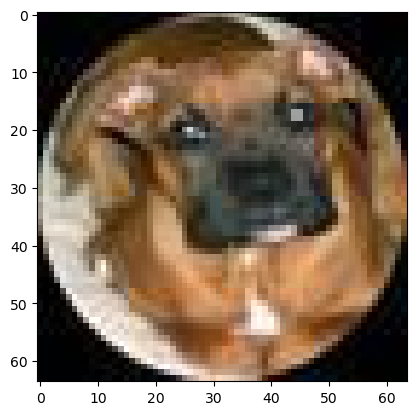

In [31]:
plt.imshow(einops.rearrange(image, "c h w -> h w c"))

In [60]:
rot_angle = 180
image_rot = torchvision.transforms.functional.rotate(image, rot_angle)

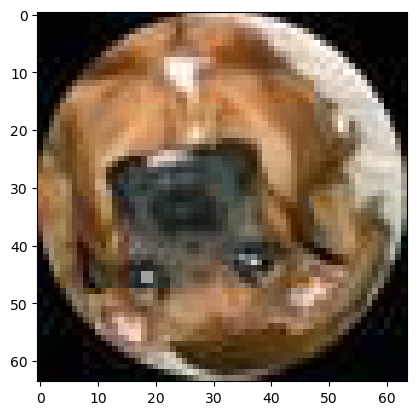

In [61]:
plt.imshow(einops.rearrange(image_rot, "c h w -> h w c"))

In [62]:
with torch.no_grad():
    map_ = model.layer3(model.layer2(model.layer1(image)))
    map_rotated = model.layer3(model.layer2(model.layer1(image_rot)))

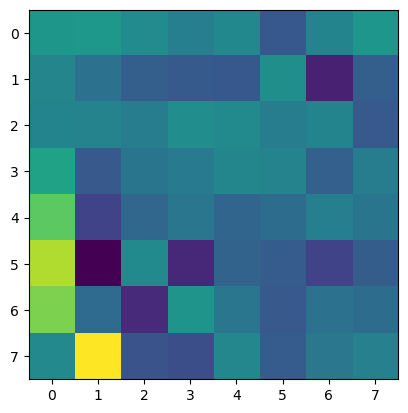

In [65]:
plt.imshow(einops.rearrange(map_, "c h w -> h w c")[:,:,0])

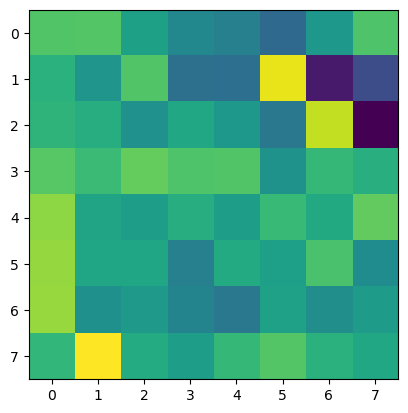

In [66]:
plt.imshow(einops.rearrange(map_rotated, "c h w -> h w c")[:,:,0])

# Augementations switched on

In [67]:
train_transform = transforms.Compose([
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(360),
                                transforms.ToTensor()
                               ])
test_transform = transforms.Compose([
#                                 transforms.Resize((128,128)),
                            transforms.ToTensor()
                           ])
dataset_Train = datasets.ImageFolder(f'./Data/Train/', transform=train_transform)
dataset_Test = datasets.ImageFolder(f'./Data/Test/', transform =test_transform)
dataloader_train = torch.utils.data.DataLoader(dataset_Train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_Test, batch_size=32, shuffle=True)

In [68]:
model = SimpleCnn(120)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose = True,threshold = 0.001,patience = 3, factor = 0.5)
model = model.to("cuda")

In [69]:
# scaler = torch.cuda.amp.GradScaler()


for epoch in range(100):
    train_loss = 0
    val_loss = 0
    train_steps = 0
    test_steps = 0
    label_list = []
    outputs_list = []
    train_auc = 0
    test_auc = 0
    model.train()
    for image, label in tqdm(dataloader_train):
        image = image.to("cuda")
        label = label.to("cuda")
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

#         with torch.cuda.amp.autocast():
        outputs = model(image)
        loss = criterion(outputs, label)
        
        with torch.no_grad():
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs.detach(), axis = 1).cpu().numpy())
        loss.backward()
        optimizer.step()
#         scaler.update()
        train_loss += loss.item()
        train_steps += 1

    with torch.no_grad():
        train_acc = accuracy_score(label_list, outputs_list)




    #-------------------------------------------------------------------
    model.eval()
    label_list = []
    outputs_list = []
    with torch.no_grad():
        for image, label in tqdm(dataloader_test):
            image = image.to("cuda")
            label = label.to("cuda")
            outputs = model(image)
            loss = criterion(outputs, label)
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs.detach(), axis = 1).cpu().numpy())
            val_loss += loss.item()
            test_steps +=1

        test_acc = accuracy_score(label_list, outputs_list)

    train_loss = train_loss/train_steps
    val_loss = val_loss/ test_steps


    print("----------------------------------------------------")
    print("Epoch No" , epoch)
    print("The Training loss of the epoch, ",train_loss)
    print("The Training accuracy of the epoch,  %.3f"%train_acc)
    print("The validation loss of the epoch, ",val_loss)
    print("The validation accuracy of the epoch, %.3f"%test_acc)
    print("----------------------------------------------------")

    scheduler.step(test_acc)
    gc.collect()


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 0
The Training loss of the epoch,  4.748623677571614
The Training accuracy of the epoch,  0.011
The validation loss of the epoch,  4.631012948472261
The validation accuracy of the epoch, 0.016
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 1
The Training loss of the epoch,  4.596867543538411
The Training accuracy of the epoch,  0.016
The validation loss of the epoch,  4.563127686099935
The validation accuracy of the epoch, 0.026
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 2
The Training loss of the epoch,  4.559199029286702
The Training accuracy of the epoch,  0.019
The validation loss of the epoch,  4.5309694088081445
The validation accuracy of the epoch, 0.026
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 3
The Training loss of the epoch,  4.536008728027344
The Training accuracy of the epoch,  0.021
The validation loss of the epoch,  4.501659464215701
The validation accuracy of the epoch, 0.024
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 4
The Training loss of the epoch,  4.4945008697509765
The Training accuracy of the epoch,  0.024
The validation loss of the epoch,  4.516219259637882
The validation accuracy of the epoch, 0.027
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 5
The Training loss of the epoch,  4.423961600621541
The Training accuracy of the epoch,  0.030
The validation loss of the epoch,  4.378689721614455
The validation accuracy of the epoch, 0.032
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 6
The Training loss of the epoch,  4.382440284729004
The Training accuracy of the epoch,  0.032
The validation loss of the epoch,  4.342787326933283
The validation accuracy of the epoch, 0.038
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 7
The Training loss of the epoch,  4.356965506871541
The Training accuracy of the epoch,  0.035
The validation loss of the epoch,  4.342343259478147
The validation accuracy of the epoch, 0.038
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 8
The Training loss of the epoch,  4.32953396542867
The Training accuracy of the epoch,  0.037
The validation loss of the epoch,  4.328535492978575
The validation accuracy of the epoch, 0.043
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 9
The Training loss of the epoch,  4.316878552118937
The Training accuracy of the epoch,  0.042
The validation loss of the epoch,  4.321310902173634
The validation accuracy of the epoch, 0.044
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 10
The Training loss of the epoch,  4.299346399943034
The Training accuracy of the epoch,  0.042
The validation loss of the epoch,  4.295874858877473
The validation accuracy of the epoch, 0.044
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 11
The Training loss of the epoch,  4.2874721260070805
The Training accuracy of the epoch,  0.043
The validation loss of the epoch,  4.317641104021037
The validation accuracy of the epoch, 0.048
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 12
The Training loss of the epoch,  4.27141152826945
The Training accuracy of the epoch,  0.044
The validation loss of the epoch,  4.24620215600308
The validation accuracy of the epoch, 0.050
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 13
The Training loss of the epoch,  4.254660617192586
The Training accuracy of the epoch,  0.050
The validation loss of the epoch,  4.285831072959758
The validation accuracy of the epoch, 0.048
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 14
The Training loss of the epoch,  4.24341588973999
The Training accuracy of the epoch,  0.049
The validation loss of the epoch,  4.264794269902112
The validation accuracy of the epoch, 0.052
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 15
The Training loss of the epoch,  4.2338342405955
The Training accuracy of the epoch,  0.051
The validation loss of the epoch,  4.22738462309855
The validation accuracy of the epoch, 0.052
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 16
The Training loss of the epoch,  4.222509909947713
The Training accuracy of the epoch,  0.054
The validation loss of the epoch,  4.2249954136774
The validation accuracy of the epoch, 0.054
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 17
The Training loss of the epoch,  4.207957319259643
The Training accuracy of the epoch,  0.053
The validation loss of the epoch,  4.224235814743325
The validation accuracy of the epoch, 0.055
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 18
The Training loss of the epoch,  4.199428365071615
The Training accuracy of the epoch,  0.054
The validation loss of the epoch,  4.233101605482704
The validation accuracy of the epoch, 0.056
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 19
The Training loss of the epoch,  4.193272181193034
The Training accuracy of the epoch,  0.058
The validation loss of the epoch,  4.269357015652284
The validation accuracy of the epoch, 0.050
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 20
The Training loss of the epoch,  4.1781363201141355
The Training accuracy of the epoch,  0.059
The validation loss of the epoch,  4.1905016154604775
The validation accuracy of the epoch, 0.058
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 21
The Training loss of the epoch,  4.168688577016194
The Training accuracy of the epoch,  0.059
The validation loss of the epoch,  4.210447796215355
The validation accuracy of the epoch, 0.056
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 22
The Training loss of the epoch,  4.151513732910156
The Training accuracy of the epoch,  0.061
The validation loss of the epoch,  4.173425347388456
The validation accuracy of the epoch, 0.060
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 23
The Training loss of the epoch,  4.145310042063395
The Training accuracy of the epoch,  0.058
The validation loss of the epoch,  4.166648215963938
The validation accuracy of the epoch, 0.066
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 24
The Training loss of the epoch,  4.139796713511149
The Training accuracy of the epoch,  0.064
The validation loss of the epoch,  4.226480426398352
The validation accuracy of the epoch, 0.057
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 25
The Training loss of the epoch,  4.129890630086263
The Training accuracy of the epoch,  0.066
The validation loss of the epoch,  4.168981946533941
The validation accuracy of the epoch, 0.061
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 26
The Training loss of the epoch,  4.114256326039632
The Training accuracy of the epoch,  0.072
The validation loss of the epoch,  4.173118122448265
The validation accuracy of the epoch, 0.062
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 27
The Training loss of the epoch,  4.11400386873881
The Training accuracy of the epoch,  0.068
The validation loss of the epoch,  4.138096601103318
The validation accuracy of the epoch, 0.066
----------------------------------------------------
Epoch 00028: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 28
The Training loss of the epoch,  4.073953964233398
The Training accuracy of the epoch,  0.071
The validation loss of the epoch,  4.112740182522061
The validation accuracy of the epoch, 0.073
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 29
The Training loss of the epoch,  4.07214555422465
The Training accuracy of the epoch,  0.074
The validation loss of the epoch,  4.109895161093389
The validation accuracy of the epoch, 0.071
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 30
The Training loss of the epoch,  4.059719165802002
The Training accuracy of the epoch,  0.075
The validation loss of the epoch,  4.110392363984346
The validation accuracy of the epoch, 0.071
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 31
The Training loss of the epoch,  4.05227763748169
The Training accuracy of the epoch,  0.077
The validation loss of the epoch,  4.118394986404362
The validation accuracy of the epoch, 0.074
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 32
The Training loss of the epoch,  4.050511990865072
The Training accuracy of the epoch,  0.079
The validation loss of the epoch,  4.10410695891398
The validation accuracy of the epoch, 0.072
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 33
The Training loss of the epoch,  4.047988730748495
The Training accuracy of the epoch,  0.076
The validation loss of the epoch,  4.10201822160345
The validation accuracy of the epoch, 0.074
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 34
The Training loss of the epoch,  4.042595616658529
The Training accuracy of the epoch,  0.081
The validation loss of the epoch,  4.107777247198452
The validation accuracy of the epoch, 0.075
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 35
The Training loss of the epoch,  4.03727579053243
The Training accuracy of the epoch,  0.080
The validation loss of the epoch,  4.08927868821807
The validation accuracy of the epoch, 0.074
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 36
The Training loss of the epoch,  4.040307404836019
The Training accuracy of the epoch,  0.078
The validation loss of the epoch,  4.085658885289302
The validation accuracy of the epoch, 0.076
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 37
The Training loss of the epoch,  4.031703356424967
The Training accuracy of the epoch,  0.080
The validation loss of the epoch,  4.073122291316773
The validation accuracy of the epoch, 0.078
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 38
The Training loss of the epoch,  4.02316351890564
The Training accuracy of the epoch,  0.078
The validation loss of the epoch,  4.087781408019225
The validation accuracy of the epoch, 0.076
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 39
The Training loss of the epoch,  4.016867450078329
The Training accuracy of the epoch,  0.080
The validation loss of the epoch,  4.087480553020775
The validation accuracy of the epoch, 0.075
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 40
The Training loss of the epoch,  4.0198491751352945
The Training accuracy of the epoch,  0.081
The validation loss of the epoch,  4.0763034492620305
The validation accuracy of the epoch, 0.074
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 41
The Training loss of the epoch,  4.01179939142863
The Training accuracy of the epoch,  0.082
The validation loss of the epoch,  4.079614768684132
The validation accuracy of the epoch, 0.074
----------------------------------------------------
Epoch 00042: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 42
The Training loss of the epoch,  3.9952567240397134
The Training accuracy of the epoch,  0.086
The validation loss of the epoch,  4.063416623714688
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 43
The Training loss of the epoch,  3.9898039786020916
The Training accuracy of the epoch,  0.084
The validation loss of the epoch,  4.074330615288263
The validation accuracy of the epoch, 0.078
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 44
The Training loss of the epoch,  3.9903142782847087
The Training accuracy of the epoch,  0.086
The validation loss of the epoch,  4.060312531694604
The validation accuracy of the epoch, 0.079
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 45
The Training loss of the epoch,  3.988529634475708
The Training accuracy of the epoch,  0.087
The validation loss of the epoch,  4.052880836685351
The validation accuracy of the epoch, 0.080
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 46
The Training loss of the epoch,  3.9807869199117025
The Training accuracy of the epoch,  0.086
The validation loss of the epoch,  4.062106350540672
The validation accuracy of the epoch, 0.077
----------------------------------------------------
Epoch 00047: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 47
The Training loss of the epoch,  3.973396473566691
The Training accuracy of the epoch,  0.090
The validation loss of the epoch,  4.056390709150237
The validation accuracy of the epoch, 0.082
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 48
The Training loss of the epoch,  3.967153865178426
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.049723198865869
The validation accuracy of the epoch, 0.082
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 49
The Training loss of the epoch,  3.9713382097880046
The Training accuracy of the epoch,  0.085
The validation loss of the epoch,  4.0567038289676365
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 50
The Training loss of the epoch,  3.9668847834269205
The Training accuracy of the epoch,  0.089
The validation loss of the epoch,  4.048788131834406
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 51
The Training loss of the epoch,  3.960505470275879
The Training accuracy of the epoch,  0.090
The validation loss of the epoch,  4.053737074025944
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 52
The Training loss of the epoch,  3.9628778813680015
The Training accuracy of the epoch,  0.089
The validation loss of the epoch,  4.050080699105245
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 53
The Training loss of the epoch,  3.966340504964193
The Training accuracy of the epoch,  0.089
The validation loss of the epoch,  4.047271085937671
The validation accuracy of the epoch, 0.080
----------------------------------------------------
Epoch 00054: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 54
The Training loss of the epoch,  3.9550124136606852
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.054346658040156
The validation accuracy of the epoch, 0.082
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 55
The Training loss of the epoch,  3.9608483085632322
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.050303359900266
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 56
The Training loss of the epoch,  3.958568604151408
The Training accuracy of the epoch,  0.088
The validation loss of the epoch,  4.0580859902179816
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 57
The Training loss of the epoch,  3.959613515853882
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.045380002947102
The validation accuracy of the epoch, 0.083
----------------------------------------------------
Epoch 00058: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 58
The Training loss of the epoch,  3.9531077810923256
The Training accuracy of the epoch,  0.089
The validation loss of the epoch,  4.045916410183818
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 59
The Training loss of the epoch,  3.9492103595733643
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.0475854315279145
The validation accuracy of the epoch, 0.082
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 60
The Training loss of the epoch,  3.9543385683695473
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.043913281983159
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 61
The Training loss of the epoch,  3.951732789993286
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.0454177510782685
The validation accuracy of the epoch, 0.083
----------------------------------------------------
Epoch 00062: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 62
The Training loss of the epoch,  3.957120293299357
The Training accuracy of the epoch,  0.088
The validation loss of the epoch,  4.045484046510604
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 63
The Training loss of the epoch,  3.951414525985718
The Training accuracy of the epoch,  0.090
The validation loss of the epoch,  4.045263338266252
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 64
The Training loss of the epoch,  3.94803977394104
The Training accuracy of the epoch,  0.090
The validation loss of the epoch,  4.04737206728485
The validation accuracy of the epoch, 0.085
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 65
The Training loss of the epoch,  3.947091868718465
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.046947962289406
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 66
The Training loss of the epoch,  3.947913257598877
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.0444019851188235
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 67
The Training loss of the epoch,  3.951594014485677
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.045535223191555
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 68
The Training loss of the epoch,  3.9515001742045084
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.046456120714379
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00069: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 69
The Training loss of the epoch,  3.946402448018392
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.046529659108159
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 70
The Training loss of the epoch,  3.9470221951802573
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.044410621366536
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 71
The Training loss of the epoch,  3.9488289794921876
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.046196436793387
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 72
The Training loss of the epoch,  3.94509499613444
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.043140056851185
The validation accuracy of the epoch, 0.083
----------------------------------------------------
Epoch 00073: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 73
The Training loss of the epoch,  3.9470937277475993
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.047943345676124
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 74
The Training loss of the epoch,  3.94638000424703
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.044224271987008
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 75
The Training loss of the epoch,  3.9483402462005617
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.041866272355544
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 76
The Training loss of the epoch,  3.9441628494262697
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.046788273247644
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00077: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 77
The Training loss of the epoch,  3.9473850866953533
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.044533655989126
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 78
The Training loss of the epoch,  3.9494574012756347
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.042994101251368
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 79
The Training loss of the epoch,  3.9448635177612306
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.048023105110821
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 80
The Training loss of the epoch,  3.948716837565104
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.045575141020424
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00081: reducing learning rate of group 0 to 9.7656e-07.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 81
The Training loss of the epoch,  3.9426795590718586
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.045554441147134
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 82
The Training loss of the epoch,  3.946024065653483
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.043539458491102
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 83
The Training loss of the epoch,  3.946289318084717
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.043809148015586
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 84
The Training loss of the epoch,  3.9467591813405356
The Training accuracy of the epoch,  0.095
The validation loss of the epoch,  4.046936129991893
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00085: reducing learning rate of group 0 to 4.8828e-07.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 85
The Training loss of the epoch,  3.947125653584798
The Training accuracy of the epoch,  0.094
The validation loss of the epoch,  4.047549091750361
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 86
The Training loss of the epoch,  3.9457367477416994
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.044509688274568
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 87
The Training loss of the epoch,  3.9508324069976806
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.046299095047451
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 88
The Training loss of the epoch,  3.9453790855407713
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.048375399139291
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00089: reducing learning rate of group 0 to 2.4414e-07.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 89
The Training loss of the epoch,  3.9461969617207844
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.0453186717618355
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 90
The Training loss of the epoch,  3.948334185918172
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.045893394370948
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 91
The Training loss of the epoch,  3.9473467280069987
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.045751219788449
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 92
The Training loss of the epoch,  3.9463129501342773
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.0459526914646196
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00093: reducing learning rate of group 0 to 1.2207e-07.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 93
The Training loss of the epoch,  3.9445454953511554
The Training accuracy of the epoch,  0.094
The validation loss of the epoch,  4.048041512975019
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 94
The Training loss of the epoch,  3.9513834953308105
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.043643678431174
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 95
The Training loss of the epoch,  3.9409109554290773
The Training accuracy of the epoch,  0.091
The validation loss of the epoch,  4.04571260927335
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 96
The Training loss of the epoch,  3.942377196629842
The Training accuracy of the epoch,  0.090
The validation loss of the epoch,  4.047976410521894
The validation accuracy of the epoch, 0.084
----------------------------------------------------
Epoch 00097: reducing learning rate of group 0 to 6.1035e-08.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 97
The Training loss of the epoch,  3.94750581741333
The Training accuracy of the epoch,  0.092
The validation loss of the epoch,  4.045548863570486
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 98
The Training loss of the epoch,  3.9427167002360024
The Training accuracy of the epoch,  0.095
The validation loss of the epoch,  4.041801828434033
The validation accuracy of the epoch, 0.084
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 99
The Training loss of the epoch,  3.9470124041239423
The Training accuracy of the epoch,  0.089
The validation loss of the epoch,  4.04940515291292
The validation accuracy of the epoch, 0.084
----------------------------------------------------


In [80]:
model = model.to("cpu")
model.eval()

SimpleCnn(
  (layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer5): AdaptiveAvgPool2d(output_size=(1, 1))
  (head): Linear(in_features=32, out_features=120, bias=True)
)

In [81]:
data = next(iter(dataloader_test))
img,label = data
image = img[0,:,:,:]

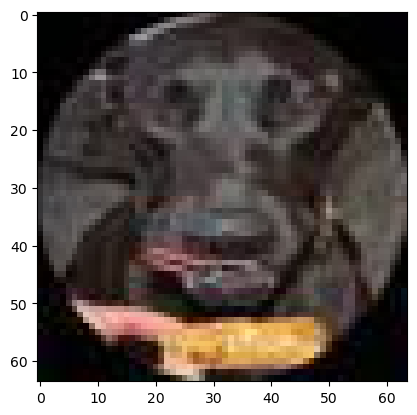

In [82]:
plt.imshow(einops.rearrange(image, "c h w -> h w c"))

In [83]:
rot_angle = 180
image_rot = torchvision.transforms.functional.rotate(image, rot_angle)

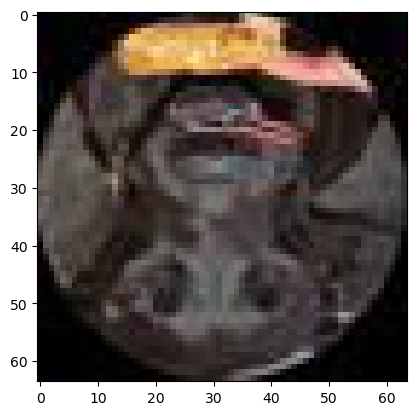

In [84]:
plt.imshow(einops.rearrange(image_rot, "c h w -> h w c"))

In [85]:
with torch.no_grad():
    map_ = model.layer3(model.layer2(model.layer1(image)))
    map_rotated = model.layer3(model.layer2(model.layer1(image_rot)))

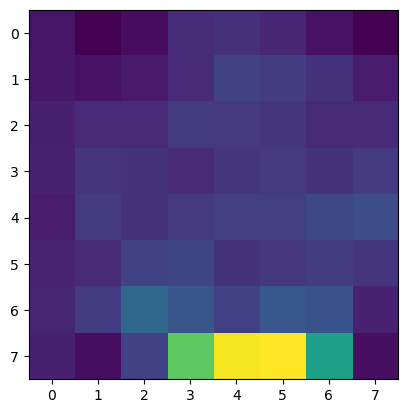

In [98]:
plt.imshow(einops.rearrange(map_, "c h w -> h w c")[:,:,3])

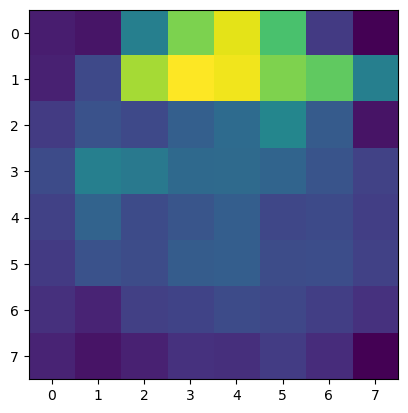

In [99]:
plt.imshow(einops.rearrange(map_rotated, "c h w -> h w c")[:,:,3])

# Invariant Network architecture
## The Invariance is with respect to rotation

In [100]:
class TrainTransform(object):
    def __init__(self):
        self.transform_normal = transforms.Compose([
                                transforms.ToTensor()
                               ])
        
        self.transform_augmented = transforms.Compose([
                                transforms.RandomRotation(360),
                                transforms.ToTensor()
                               ])


    def __call__(self, sample):
        normal = self.transform_normal(sample)
        augmented = self.transform_augmented(sample)
        return normal, augmented

In [101]:
train_transform = TrainTransform()
test_transform = transforms.Compose([transforms.ToTensor()])

dataset_Train = datasets.ImageFolder(f'./Data/Train/', transform=train_transform)
dataset_Test = datasets.ImageFolder(f'./Data/Test/', transform =test_transform)
dataloader_train = torch.utils.data.DataLoader(dataset_Train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_Test, batch_size=32, shuffle=True)

model = SimpleCnn(120)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose = True,threshold = 0.001,patience = 3, factor = 0.5)
model = model.to("cuda")

In [115]:
data = next(iter(dataloader_train))
img,label = data
normal = img[0][0,...]
augmented = img[1][0,...]

In [116]:
label

tensor([ 55,  36,   8,  43,  70,   8,  85,  39,  30,  59, 100,  32, 107,  57,
         95,  47,  36,  59,  17,  42,  13,  70,   3,  64, 105,  48, 110,  63,
         10,  71, 110,  87])

In [110]:
normal.shape

torch.Size([3, 64, 64])

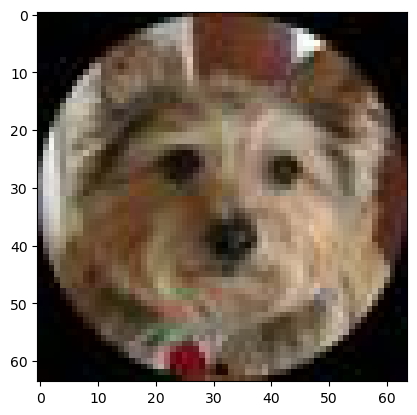

In [111]:
plt.imshow(einops.rearrange(normal, "c h w -> h w c"))

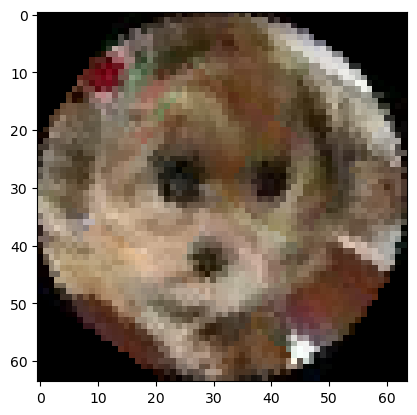

In [112]:
plt.imshow(einops.rearrange(augmented, "c h w -> h w c"))

In [122]:
# scaler = torch.cuda.amp.GradScaler()


for epoch in range(100):
    train_loss = 0
    val_loss = 0
    train_steps = 0
    test_steps = 0
    label_list = []
    outputs_list = []
    train_auc = 0
    test_auc = 0
    model.train()
    for image, label in tqdm(dataloader_train):
        normal,augmented = image
        
        normal = normal.to("cuda")
        augmented = augmented.to("cuda")
        label = label.to("cuda")
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

#         with torch.cuda.amp.autocast():
        outputs_normal = model(normal)
        outputs_augmented = model(augmented)
        
        loss_classification = criterion(outputs_normal, label)
        loss_invariance = nn.functional.mse_loss(outputs_normal,outputs_augmented)
        
        loss = loss_classification + (1/25)*loss_invariance
        
        with torch.no_grad():
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs_normal.detach(), axis = 1).cpu().numpy())
        loss.backward()
        optimizer.step()
#         scaler.update()
        train_loss += loss.item()
        train_steps += 1

    with torch.no_grad():
        train_acc = accuracy_score(label_list, outputs_list)




    #-------------------------------------------------------------------
    model.eval()
    label_list = []
    outputs_list = []
    with torch.no_grad():
        for image, label in tqdm(dataloader_test):
            image = image.to("cuda")
            label = label.to("cuda")
            outputs = model(image)
            loss = criterion(outputs, label)
            label_list.extend(label.detach().cpu().numpy())
            outputs_list.extend(torch.argmax(outputs.detach(), axis = 1).cpu().numpy())
            val_loss += loss.item()
            test_steps +=1

        test_acc = accuracy_score(label_list, outputs_list)

    train_loss = train_loss/train_steps
    val_loss = val_loss/ test_steps


    print("----------------------------------------------------")
    print("Epoch No" , epoch)
    print("The Training loss of the epoch, ",train_loss)
    print("The Training accuracy of the epoch,  %.3f"%train_acc)
    print("The validation loss of the epoch, ",val_loss)
    print("The validation accuracy of the epoch, %.3f"%test_acc)
    print("----------------------------------------------------")

    scheduler.step(test_acc)
    gc.collect()


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 0
The Training loss of the epoch,  4.612913162231445
The Training accuracy of the epoch,  0.017
The validation loss of the epoch,  4.583470229322582
The validation accuracy of the epoch, 0.019
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 1
The Training loss of the epoch,  4.567563824971517
The Training accuracy of the epoch,  0.017
The validation loss of the epoch,  4.551873231909089
The validation accuracy of the epoch, 0.026
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 2
The Training loss of the epoch,  4.538909764607747
The Training accuracy of the epoch,  0.022
The validation loss of the epoch,  4.537157815628335
The validation accuracy of the epoch, 0.021
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 3
The Training loss of the epoch,  4.501931357065836
The Training accuracy of the epoch,  0.024
The validation loss of the epoch,  4.459460653780118
The validation accuracy of the epoch, 0.025
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 4
The Training loss of the epoch,  4.39722610727946
The Training accuracy of the epoch,  0.036
The validation loss of the epoch,  4.344006338084054
The validation accuracy of the epoch, 0.040
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 5
The Training loss of the epoch,  4.309517780939738
The Training accuracy of the epoch,  0.044
The validation loss of the epoch,  4.296144240850853
The validation accuracy of the epoch, 0.050
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 6
The Training loss of the epoch,  4.256099360783895
The Training accuracy of the epoch,  0.051
The validation loss of the epoch,  4.2644735942542775
The validation accuracy of the epoch, 0.053
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 7
The Training loss of the epoch,  4.21229706954956
The Training accuracy of the epoch,  0.055
The validation loss of the epoch,  4.209563633766316
The validation accuracy of the epoch, 0.057
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 8
The Training loss of the epoch,  4.17785125986735
The Training accuracy of the epoch,  0.062
The validation loss of the epoch,  4.19464375981611
The validation accuracy of the epoch, 0.060
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 9
The Training loss of the epoch,  4.141608885447185
The Training accuracy of the epoch,  0.066
The validation loss of the epoch,  4.153135362610941
The validation accuracy of the epoch, 0.065
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 10
The Training loss of the epoch,  4.1069781227111815
The Training accuracy of the epoch,  0.072
The validation loss of the epoch,  4.15467582582098
The validation accuracy of the epoch, 0.059
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 11
The Training loss of the epoch,  4.088398131052653
The Training accuracy of the epoch,  0.076
The validation loss of the epoch,  4.1150323201289405
The validation accuracy of the epoch, 0.070
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 12
The Training loss of the epoch,  4.0545090942382815
The Training accuracy of the epoch,  0.084
The validation loss of the epoch,  4.106995277688406
The validation accuracy of the epoch, 0.071
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 13
The Training loss of the epoch,  4.027564531326294
The Training accuracy of the epoch,  0.085
The validation loss of the epoch,  4.117388891907873
The validation accuracy of the epoch, 0.064
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 14
The Training loss of the epoch,  4.00218156115214
The Training accuracy of the epoch,  0.087
The validation loss of the epoch,  4.0803245354762305
The validation accuracy of the epoch, 0.076
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 15
The Training loss of the epoch,  3.9781709073384603
The Training accuracy of the epoch,  0.093
The validation loss of the epoch,  4.0498354204525295
The validation accuracy of the epoch, 0.080
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 16
The Training loss of the epoch,  3.959430121739705
The Training accuracy of the epoch,  0.095
The validation loss of the epoch,  4.029524784549018
The validation accuracy of the epoch, 0.081
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 17
The Training loss of the epoch,  3.934783571243286
The Training accuracy of the epoch,  0.097
The validation loss of the epoch,  4.0272597371423995
The validation accuracy of the epoch, 0.076
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 18
The Training loss of the epoch,  3.916841486612956
The Training accuracy of the epoch,  0.098
The validation loss of the epoch,  3.9972310110538865
The validation accuracy of the epoch, 0.090
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 19
The Training loss of the epoch,  3.9081563046773273
The Training accuracy of the epoch,  0.100
The validation loss of the epoch,  3.9972832849920903
The validation accuracy of the epoch, 0.085
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 20
The Training loss of the epoch,  3.8906914761861167
The Training accuracy of the epoch,  0.105
The validation loss of the epoch,  3.9884181572158983
The validation accuracy of the epoch, 0.085
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 21
The Training loss of the epoch,  3.87416953531901
The Training accuracy of the epoch,  0.108
The validation loss of the epoch,  3.9760221646177722
The validation accuracy of the epoch, 0.091
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 22
The Training loss of the epoch,  3.858156997044881
The Training accuracy of the epoch,  0.110
The validation loss of the epoch,  4.008939080078806
The validation accuracy of the epoch, 0.083
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 23
The Training loss of the epoch,  3.846807253519694
The Training accuracy of the epoch,  0.111
The validation loss of the epoch,  3.9824614152589253
The validation accuracy of the epoch, 0.086
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 24
The Training loss of the epoch,  3.8320298252105713
The Training accuracy of the epoch,  0.115
The validation loss of the epoch,  3.965361083750388
The validation accuracy of the epoch, 0.090
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 25
The Training loss of the epoch,  3.81738546816508
The Training accuracy of the epoch,  0.113
The validation loss of the epoch,  3.960673055684256
The validation accuracy of the epoch, 0.093
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 26
The Training loss of the epoch,  3.8068272616068524
The Training accuracy of the epoch,  0.116
The validation loss of the epoch,  3.9484111890473774
The validation accuracy of the epoch, 0.093
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 27
The Training loss of the epoch,  3.793253303527832
The Training accuracy of the epoch,  0.121
The validation loss of the epoch,  3.9427252498258003
The validation accuracy of the epoch, 0.096
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 28
The Training loss of the epoch,  3.7739328479766847
The Training accuracy of the epoch,  0.123
The validation loss of the epoch,  3.9296413841743894
The validation accuracy of the epoch, 0.101
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 29
The Training loss of the epoch,  3.7694780934651693
The Training accuracy of the epoch,  0.123
The validation loss of the epoch,  3.921942393575902
The validation accuracy of the epoch, 0.102
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 30
The Training loss of the epoch,  3.757955245335897
The Training accuracy of the epoch,  0.124
The validation loss of the epoch,  3.9557242570756537
The validation accuracy of the epoch, 0.093
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 31
The Training loss of the epoch,  3.733553476969401
The Training accuracy of the epoch,  0.132
The validation loss of the epoch,  3.921076770165596
The validation accuracy of the epoch, 0.097
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 32
The Training loss of the epoch,  3.7253388748168947
The Training accuracy of the epoch,  0.132
The validation loss of the epoch,  3.9373877075081865
The validation accuracy of the epoch, 0.099
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 33
The Training loss of the epoch,  3.7228294887542726
The Training accuracy of the epoch,  0.130
The validation loss of the epoch,  3.9455687051368913
The validation accuracy of the epoch, 0.100
----------------------------------------------------
Epoch 00034: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 34
The Training loss of the epoch,  3.6719969437917075
The Training accuracy of the epoch,  0.142
The validation loss of the epoch,  3.9086225449374172
The validation accuracy of the epoch, 0.099
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 35
The Training loss of the epoch,  3.664410753885905
The Training accuracy of the epoch,  0.144
The validation loss of the epoch,  3.887407060006294
The validation accuracy of the epoch, 0.102
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 36
The Training loss of the epoch,  3.6564639110565187
The Training accuracy of the epoch,  0.145
The validation loss of the epoch,  3.9096653071477956
The validation accuracy of the epoch, 0.106
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 37
The Training loss of the epoch,  3.651870594024658
The Training accuracy of the epoch,  0.147
The validation loss of the epoch,  3.9181259999044764
The validation accuracy of the epoch, 0.101
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 38
The Training loss of the epoch,  3.646184409459432
The Training accuracy of the epoch,  0.147
The validation loss of the epoch,  3.9102835025929163
The validation accuracy of the epoch, 0.103
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 39
The Training loss of the epoch,  3.638413507461548
The Training accuracy of the epoch,  0.149
The validation loss of the epoch,  3.9087686804590613
The validation accuracy of the epoch, 0.104
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 40
The Training loss of the epoch,  3.633744586308797
The Training accuracy of the epoch,  0.150
The validation loss of the epoch,  3.8944213860096983
The validation accuracy of the epoch, 0.107
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 41
The Training loss of the epoch,  3.6282637424468995
The Training accuracy of the epoch,  0.152
The validation loss of the epoch,  3.888753054310398
The validation accuracy of the epoch, 0.106
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 42
The Training loss of the epoch,  3.623453472773234
The Training accuracy of the epoch,  0.153
The validation loss of the epoch,  3.896573246633253
The validation accuracy of the epoch, 0.105
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 43
The Training loss of the epoch,  3.6182550512949625
The Training accuracy of the epoch,  0.149
The validation loss of the epoch,  3.904015585392381
The validation accuracy of the epoch, 0.103
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 44
The Training loss of the epoch,  3.612326105753581
The Training accuracy of the epoch,  0.153
The validation loss of the epoch,  3.894366802336115
The validation accuracy of the epoch, 0.103
----------------------------------------------------
Epoch 00045: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 45
The Training loss of the epoch,  3.586900017420451
The Training accuracy of the epoch,  0.160
The validation loss of the epoch,  3.8805678112356192
The validation accuracy of the epoch, 0.109
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 46
The Training loss of the epoch,  3.582387987136841
The Training accuracy of the epoch,  0.159
The validation loss of the epoch,  3.9049369508892187
The validation accuracy of the epoch, 0.104
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 47
The Training loss of the epoch,  3.5774214941660563
The Training accuracy of the epoch,  0.160
The validation loss of the epoch,  3.880836719030784
The validation accuracy of the epoch, 0.107
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 48
The Training loss of the epoch,  3.573642421722412
The Training accuracy of the epoch,  0.161
The validation loss of the epoch,  3.8905463573214734
The validation accuracy of the epoch, 0.106
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 49
The Training loss of the epoch,  3.5699652919769287
The Training accuracy of the epoch,  0.163
The validation loss of the epoch,  3.8769124396228434
The validation accuracy of the epoch, 0.109
----------------------------------------------------
Epoch 00050: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 50
The Training loss of the epoch,  3.556633275985718
The Training accuracy of the epoch,  0.165
The validation loss of the epoch,  3.878239890456643
The validation accuracy of the epoch, 0.105
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 51
The Training loss of the epoch,  3.554070515314738
The Training accuracy of the epoch,  0.168
The validation loss of the epoch,  3.873071277008624
The validation accuracy of the epoch, 0.109
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 52
The Training loss of the epoch,  3.5544290968577066
The Training accuracy of the epoch,  0.167
The validation loss of the epoch,  3.8730639852998867
The validation accuracy of the epoch, 0.110
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 53
The Training loss of the epoch,  3.5515973739624025
The Training accuracy of the epoch,  0.164
The validation loss of the epoch,  3.886171285104574
The validation accuracy of the epoch, 0.107
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 54
The Training loss of the epoch,  3.5519730364481608
The Training accuracy of the epoch,  0.165
The validation loss of the epoch,  3.875508477696699
The validation accuracy of the epoch, 0.109
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 55
The Training loss of the epoch,  3.548238847732544
The Training accuracy of the epoch,  0.167
The validation loss of the epoch,  3.8844340689563395
The validation accuracy of the epoch, 0.109
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 56
The Training loss of the epoch,  3.5482187487284342
The Training accuracy of the epoch,  0.168
The validation loss of the epoch,  3.8815200754257826
The validation accuracy of the epoch, 0.106
----------------------------------------------------
Epoch 00057: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 57
The Training loss of the epoch,  3.539438784281413
The Training accuracy of the epoch,  0.170
The validation loss of the epoch,  3.8784586009482913
The validation accuracy of the epoch, 0.110
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 58
The Training loss of the epoch,  3.5379204457600912
The Training accuracy of the epoch,  0.171
The validation loss of the epoch,  3.8727982451924605
The validation accuracy of the epoch, 0.111
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

----------------------------------------------------
Epoch No 59
The Training loss of the epoch,  3.5383952910105387
The Training accuracy of the epoch,  0.169
The validation loss of the epoch,  3.8755267020938122
The validation accuracy of the epoch, 0.108
----------------------------------------------------


  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Switching on the rotation again

In [130]:
model = model.to("cpu")
model.eval()

SimpleCnn(
  (layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (layer5): AdaptiveAvgPool2d(output_size=(1, 1))
  (head): Linear(in_features=32, out_features=120, bias=True)
)

In [125]:
data = next(iter(dataloader_test))
img,label = data
image = img[0,:,:,:]

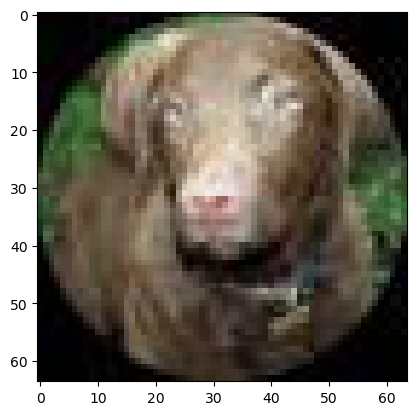

In [126]:
plt.imshow(einops.rearrange(image, "c h w -> h w c"))

In [127]:
rot_angle = 180
image_rot = torchvision.transforms.functional.rotate(image, rot_angle)

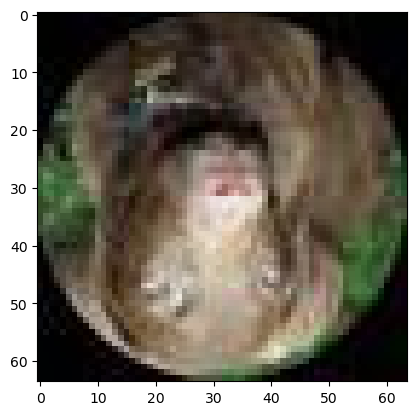

In [128]:
plt.imshow(einops.rearrange(image_rot, "c h w -> h w c"))

In [166]:
with torch.no_grad():
    map_ = model.layer3(model.layer2(model.layer1(image)))
    map_rotated = model.layer3(model.layer2(model.layer1(image_rot)))
#     map_ = model.layer2(model.layer1(image))
#     map_rotated = model.layer2(model.layer1(image_rot))

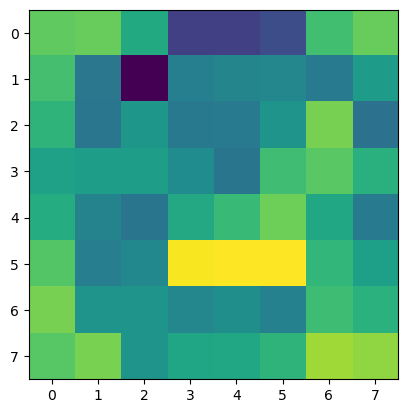

In [169]:
plt.imshow(einops.rearrange(map_, "c h w -> h w c")[:,:,0])

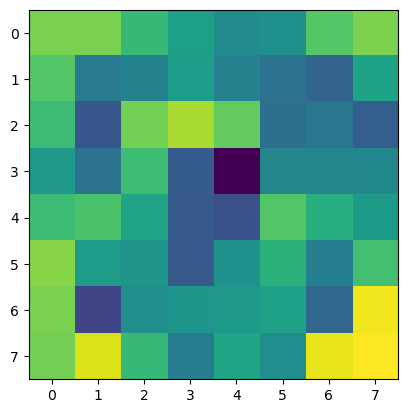

In [170]:
plt.imshow(einops.rearrange(map_rotated, "c h w -> h w c")[:,:,0])